# CDSDS 542 - Spring 2026 - Discussion 6: Regularization

[![](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/DL4DS/fa2026_discussions/blob/main/discussion_06.ipynb)

Last discussion we talked about generalization gap between trainning data and test data. In this session, we'll explore how different forms of **regularization** affect model generalization.  


In [1]:
# imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset
torch.manual_seed(42)

import numpy as np
import matplotlib.pyplot as plt

# download dataset
!pip install mnist1d --quiet
import mnist1d
from mnist1d.data import make_dataset, get_dataset_args

Dataset: MNIST1D, see https://github.com/greydanus/mnist1d

In [2]:
defaults = get_dataset_args()                                                 # load mnist1d data from mnist1d.data
dataset = make_dataset(defaults)

x_train, x_test = torch.Tensor(dataset['x']), torch.Tensor(dataset['x_test']) # load tensors
y_train, y_test = torch.LongTensor(dataset['y']), torch.LongTensor(dataset['y_test'])

train_ds = TensorDataset(x_train, y_train)                                    # define the dataset
test_ds  = TensorDataset(x_test, y_test)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=128, shuffle=False)

print(f"MNIST-1D loaded\n Train: {len(train_ds)}, Test: {len(test_ds)}, Feature length: {x_train.shape[1]}")

MNIST-1D loaded
 Train: 4000, Test: 1000, Feature length: 40


Define the Neural Network

In [3]:
# let's try with a 3-hidden layers network
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(40, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 10)
        )

    def forward(self, x):
      return self.net(x)

Train \& Evaluation tools

In [4]:
def train_eval(model, optimizer, epochs=50, weight_decay=0.0):
    criterion = nn.CrossEntropyLoss()
    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        for X, y in train_loader:
            optimizer.zero_grad()
            out = model(X)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()

        # Evaluate
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X, y in test_loader:
                val_loss += criterion(model(X), y).item()
        val_losses.append(val_loss / len(test_loader))
        train_losses.append(loss.item())

    return train_losses, val_losses

## 1. Explicit Regularization

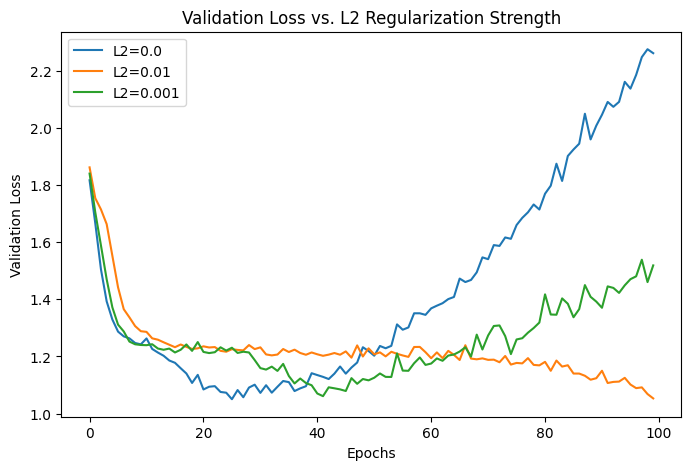

In [5]:
# Train with different L2 penalties
lambdas = [0.0, 1e-2, 1e-3]
plt.figure(figsize=(8,5))

for lam in lambdas:
    model = MLP()
    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=lam)
    tr_loss, val_loss = train_eval(model, optimizer, epochs=100)
    plt.plot(val_loss, label=f"L2={lam}")

plt.title("Validation Loss vs. L2 Regularization Strength")
plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
plt.legend()
plt.show()

## 2. Implicit Regularization

### **Exercise 1: Train with different learning rates**

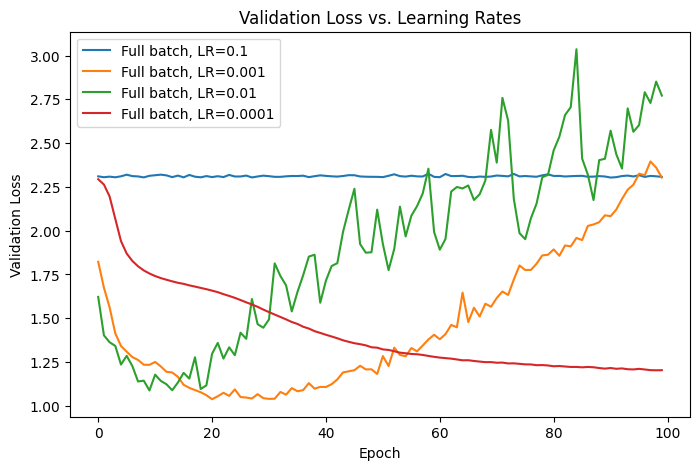

In [6]:
#Train with different learning rates
learning_rates = [1e-1, 1e-3, 1e-2, 1e-4]
plt.figure(figsize=(8,5))

for lr in learning_rates:

  # TODO: define the training process
  model = MLP()
  optimizer = optim.Adam(model.parameters(), lr=lr)
  tr_loss, val_loss = train_eval(model, optimizer, epochs=100)
  plt.plot(val_loss, label=f"Full batch, LR={lr}")

plt.title("Validation Loss vs. Learning Rates")
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.legend()
plt.show()

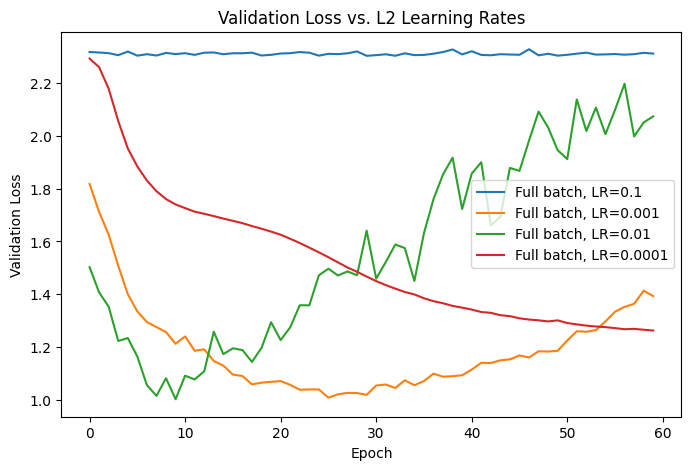

In [ ]:
# expected output

### **Exercise 2: Train with different batch sizes**

Batch size =   16 | Training time = 42.77 seconds
Batch size =   64 | Training time = 14.59 seconds
Batch size =  512 | Training time = 7.59 seconds
Batch size = 4000 | Training time = 6.59 seconds


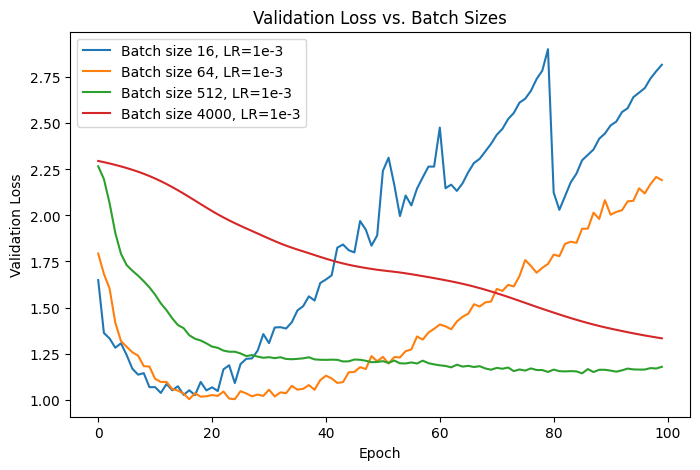

In [7]:
import time

#Train with different batch sizes
batch_sizes = [16, 64, 512, 4000]
plt.figure(figsize=(8,5))

for bs in batch_sizes:

  start_time = time.time()

  # TODO: use batch_size=bs to define another training Dataloader with `torch.utils.data.Dataloader`
  # same logic as the train_eval function above
  train_loader_small = DataLoader(train_ds, batch_size=bs, shuffle=True)
  model = MLP()
  optimizer = optim.Adam(model.parameters(), lr=1e-3)

  criterion = nn.CrossEntropyLoss()
  tr_losses, val_losses = [], []
  for epoch in range(100):
      model.train()
      for X, y in train_loader_small:
          optimizer.zero_grad()
          out = model(X)
          loss = criterion(out, y)
          loss.backward()
          optimizer.step()

      model.eval()
      val_loss = 0
      with torch.no_grad():
          for X, y in test_loader:
              val_loss += criterion(model(X), y).item()
      val_losses.append(val_loss / len(test_loader))
      tr_losses.append(loss.item())

  plt.plot(val_losses, label=f"Batch size {bs}, LR=1e-3")
  elapsed = time.time() - start_time
  print(f"Batch size = {bs:4d} | Training time = {elapsed:.2f} seconds")

plt.title("Validation Loss vs. Batch Sizes")
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.legend()
plt.show()

Batch size =   16 | Training time = 51.10 seconds
Batch size =   64 | Training time = 19.38 seconds
Batch size =  512 | Training time = 7.67 seconds
Batch size = 4000 | Training time = 9.05 seconds


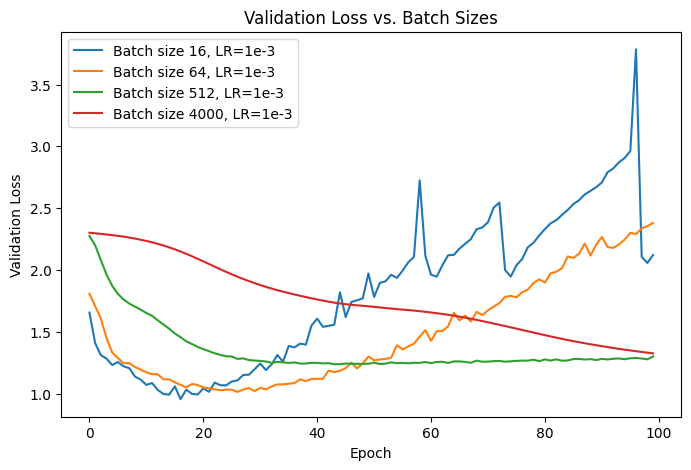

In [ ]:
# expected output

### **Exercise 3: Analyzing the benefit of early stopping**

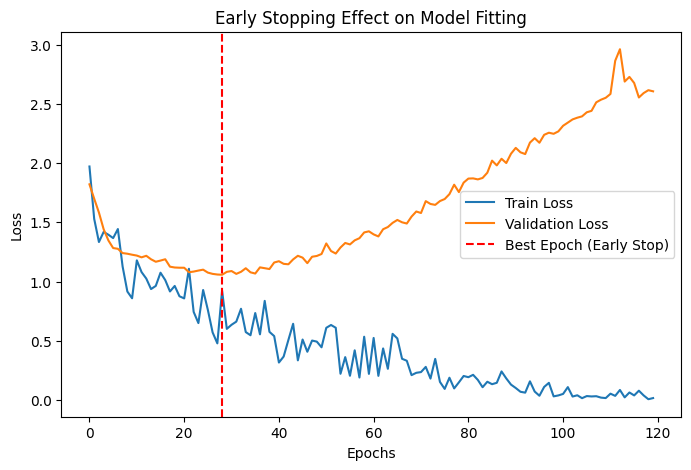

In [8]:
model = MLP()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
tr, val = train_eval(model, optimizer, epochs=120)

# TODO: select the best epoch
best_epoch = np.argmin(val)

plt.figure(figsize=(8,5))
plt.plot(tr, label="Train Loss")
plt.plot(val, label="Validation Loss")
plt.axvline(best_epoch, color='r', linestyle='--', label="Best Epoch (Early Stop)")
plt.title("Early Stopping Effect on Model Fitting")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


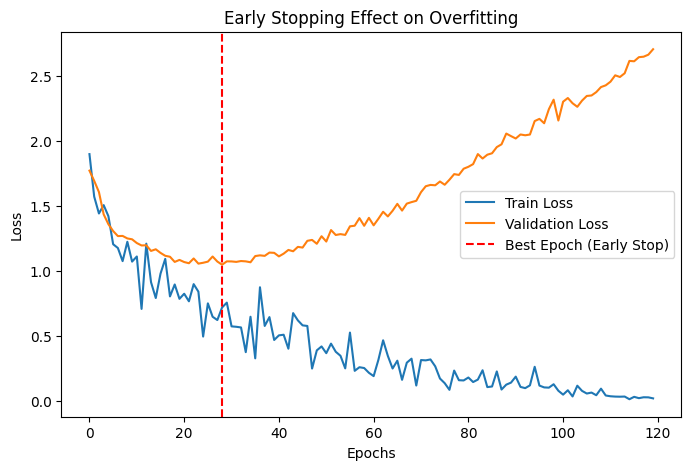

In [ ]:
# expected output

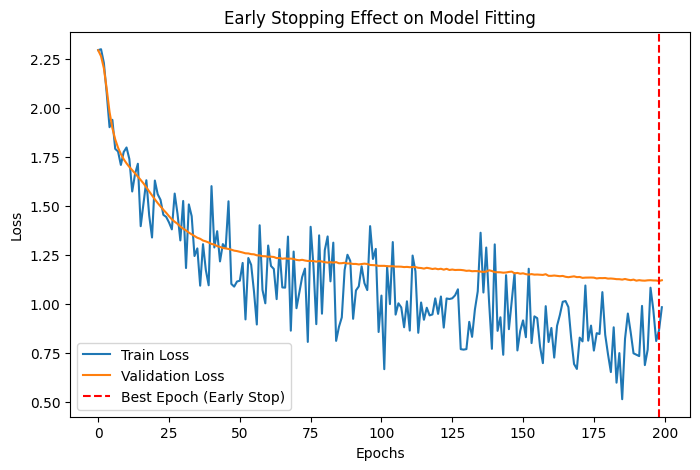

In [9]:
# try a smaller learning rate
model = MLP()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
tr, val = train_eval(model, optimizer, epochs=200)

# TODO: select the best epoch
best_epoch = np.argmin(val)

plt.figure(figsize=(8,5))
plt.plot(tr, label="Train Loss")
plt.plot(val, label="Validation Loss")
plt.axvline(best_epoch, color='r', linestyle='--', label="Best Epoch (Early Stop)")
plt.title("Early Stopping Effect on Model Fitting")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

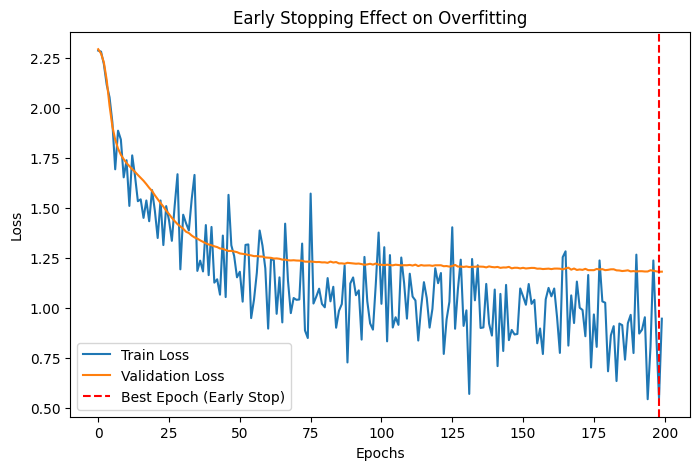

In [ ]:
# expected output